# Upbit API를 이용한 데이터 수집
3초마다 200개의 자료를 수집하여 저장

In [1]:
from modules.local_values import raw_datas, tickers, raw_folder

from datetime import datetime, timedelta
import pandas as pd
import requests
import time
import json
import os

def request_data(tick,to_time='',count=200):
    headers = {"accept":"application/json"}
    url=f'https://api.upbit.com/v1/candles/minutes/1?market={tick}&count={count}{to_time}'
    response=requests.get(url, headers=headers)
    return response.text

# json to DataFrame
def resToDF(json_text):
    contents = json.loads(json_text)
    contents = pd.DataFrame(contents,columns=[
                                'candle_date_time_kst','opening_price','high_price','low_price',
                                'trade_price','candle_acc_trade_volume','candle_acc_trade_price'])
    contents = contents.set_index('candle_date_time_kst')
    contents.index=pd.to_datetime(contents.index)
    return contents

def get_line_time(file_name, line_number):
    try: 
        with open(file_name, "r") as f:
            line = f.readlines()[line_number].strip().split(",")
            return datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S')
    except ValueError:
        print("empty file:", file_name)
        return datetime.now()
    
def collect_data(tick, to_time):
    file_name=raw_folder+tick+'.csv'
    tick_len=0
    while True:
        dtime=(to_time-timedelta(hours=9)).strftime('%Y-%m-%dT%H:%M:%S')
        contents=resToDF(request_data(tick,"&to="+dtime))
        time.sleep(3)
        to_time=contents.index[-1]
        contents.to_csv(file_name,mode='a',header=False)
        tick_len += contents.shape[0]
        if contents.shape[0] != 200:
            print(f'{tick} updates ~ {to_time} = {tick_len} length')
            break
            


In [2]:
if os.path.exists(raw_folder)==False:
    os.makedirs(raw_folder)

for tick in tickers:
    file_name=raw_folder+tick+'.csv'
    ## make file
    if os.path.exists(file_name)==False:
        with open(file_name,'w') as file:
            file.write(",open,high,low,close,volume,value\n")
        to_time = get_line_time(file_name,-1)
        collect_data(tick, to_time)
    ## update file
    else:
        end_time = get_line_time(file_name,-1)+timedelta(minutes=1)
        contents=resToDF(request_data(tick))
        while True:
            contents=contents[:end_time]
            if (contents.shape[0] == 0):
                break
            contents.to_csv(file_name,mode='a',header=False)
            time.sleep(3)
            to_time=contents.index[-1]
            dtime=(to_time-timedelta(hours=9)).strftime('%Y-%m-%dT%H:%M:%S')
            contents=resToDF(request_data(tick,"&to="+dtime))

        print(f"update {tick} to {dtime}")

for raw_file,tick in zip(raw_datas,tickers):
    df=pd.read_csv(raw_file,parse_dates=[0],index_col=[0])
    df=df.sort_index()
    df=df.loc[~df.index.duplicated(keep='first')]
    df.to_csv(raw_file)
    print(f"Sort {tick}")

update KRW-BTC to 2024-03-19T13:08:00
update KRW-ETH to 2024-03-19T13:08:00
update KRW-XRP to 2024-03-19T13:08:00
update KRW-SOL to 2024-03-19T13:08:00
update KRW-AVAX to 2024-03-19T13:08:00
update KRW-DOGE to 2024-03-19T13:08:00
update KRW-ETC to 2024-03-19T13:08:00
Sort KRW-BTC
Sort KRW-ETH
Sort KRW-XRP
Sort KRW-SOL
Sort KRW-AVAX
Sort KRW-DOGE
Sort KRW-ETC


### Data 파악
|index|open|high|low|close|volume|value|
|-----|----|----|---|-----|------|-----|
|UTC 기준|시가|고가|저가|종가|누적 거래량|누적 거래금액|

In [3]:
from modules.local_values import tickers, raw_datas
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pd.set_option('float_format', '{:.2f}'.format)
df = pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])
df.describe()

,open,high,low,close,volume,value
count,3248599.00,3248598.00,3248598.00,3248598.00,3248598.00,3248598.00
mean,27409840.20,27423547.20,27395891.65,27409751.62,5.57,147838032.93
std,21349876.16,21360146.69,21339310.04,21349788.18,10.69,323421773.30
min,1982500.00,3568000.00,3562000.00,3565000.00,0.00,0.04
25%,9470000.00,9476000.00,9464000.00,9470000.00,0.93,14546083.74
50%,20857000.00,20870000.00,20844000.00,20857000.00,2.43,49468974.39
75%,40166000.00,40180000.00,40151000.00,40166000.00,5.81,150009654.54
max,105000000.00,105000000.00,104999000.00,105000000.00,718.86,32606011609.39


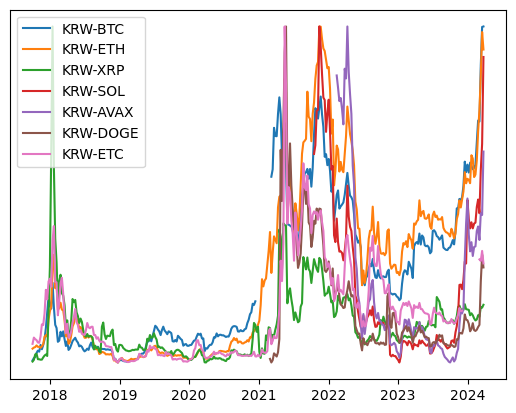

In [5]:
for file_name,tick in zip(raw_datas,tickers):
    df=pd.read_csv(file_name,parse_dates=[0],index_col=[0])
    df=df.resample(rule='W').first()
    df_min_max=df['close']-df['close'].min()
    df_min_max=df_min_max/df_min_max.max()
    plt.plot(df_min_max,label=tick)

plt.yticks([],[])
plt.legend()
plt.show()

### 결측 데이터 확인
NaN 값 확인

In [6]:
for file_name,tick in zip(raw_datas,tickers):
    df=pd.read_csv(file_name,parse_dates=[0],index_col=[0])
    df=df.resample(rule='T').first()
    msg='Data{:>9}\tTotal:{:>8}\t NaN:{:7}' \
        .format(tick,len(df),df['open'].isnull().sum())
    print(msg)

Data  KRW-BTC	Total: 3408447	 NaN: 159848
Data  KRW-ETH	Total: 3408475	 NaN: 187600
Data  KRW-XRP	Total: 3407969	 NaN: 201325
Data  KRW-SOL	Total: 1276228	 NaN:  38587
Data KRW-AVAX	Total: 1108857	 NaN: 241789
Data KRW-DOGE	Total: 1611606	 NaN:  38362
Data  KRW-ETC	Total: 3408427	 NaN: 980782


#### KRW-BTC를 대표로 확인

In [7]:
df = pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])
df['diff']=df.index.to_series().diff().dt.total_seconds()/-60-1
df[df['diff']>0]['diff'].value_counts().sort_index()

Series([], Name: count, dtype: int64)

In [8]:
print(df[df['diff']>0]['diff'].count())
print(df[df['diff']>20]['diff'].count())

0
0


확인해 봤을 때, 1분간 거래가 없었던 경우는 꽤 흔하게 나타났다.   
그에 따라 한 10분까지는 거래가 없었을 수 있다고 본다.